In [6]:
import pandas as pd

# Load the E-Commerce Dataset
eCommerce_data = pd.read_excel('../data/raw/E Commerce Dataset.xlsx')
ecommerce_data_cleaned = eCommerce_data.copy()

# Data Cleaning
# Removing impossible values, for example, negative values in numerical columns that should only have positive values.
for column in ['Tenure', 'WarehouseToHome', 'HourSpendOnApp', 'OrderAmountHikeFromlastYear', 'CouponUsed', 'OrderCount', 'DaySinceLastOrder', 'CashbackAmount']:
    ecommerce_data_cleaned = ecommerce_data_cleaned[ecommerce_data_cleaned[column] >= 0]

# Removing CustomerID duplicates, if any.
ecommerce_data_cleaned = ecommerce_data_cleaned.drop_duplicates(subset=['CustomerID'])

# Handling Missing Values
from sklearn.impute import SimpleImputer

# Numerical imputer
num_imputer = SimpleImputer(strategy='mean')
ecommerce_data_cleaned[['Tenure', 'WarehouseToHome', 'HourSpendOnApp', 'OrderAmountHikeFromlastYear', 'CouponUsed', 'OrderCount', 'DaySinceLastOrder']] = num_imputer.fit_transform(ecommerce_data_cleaned[['Tenure', 'WarehouseToHome', 'HourSpendOnApp', 'OrderAmountHikeFromlastYear', 'CouponUsed', 'OrderCount', 'DaySinceLastOrder']])

# Ensure no more missing values
missing_values_after_imputation = ecommerce_data_cleaned.isnull().sum()

missing_values_after_imputation

CustomerID                     0
Churn                          0
Tenure                         0
PreferredLoginDevice           0
CityTier                       0
WarehouseToHome                0
PreferredPaymentMode           0
Gender                         0
HourSpendOnApp                 0
NumberOfDeviceRegistered       0
PreferedOrderCat               0
SatisfactionScore              0
MaritalStatus                  0
NumberOfAddress                0
Complain                       0
OrderAmountHikeFromlastYear    0
CouponUsed                     0
OrderCount                     0
DaySinceLastOrder              0
CashbackAmount                 0
dtype: int64

In [7]:
# Encoding Categorical Variables
categorical_features = ecommerce_data_cleaned.select_dtypes(include=['object', 'category']).columns
ecommerce_data_encoded = pd.get_dummies(ecommerce_data_cleaned, columns=categorical_features, drop_first=True)

# Display the encoded dataset structure
ecommerce_data_encoded.shape

(3774, 31)

In [8]:
# Feature Engineering
# Introducing a new feature: AvgSpending = OrderAmountHikeFromlastYear * CashbackAmount
eCommerce_data['AvgSpending'] = eCommerce_data['OrderAmountHikeFromlastYear'] * eCommerce_data['CashbackAmount']

# Also, combining Tenure and NumberOfDeviceRegistered into a new feature: DeviceEngagementIndex = Tenure * NumberOfDeviceRegistered
eCommerce_data['DeviceEngagementIndex'] = eCommerce_data['Tenure'] * eCommerce_data['NumberOfDeviceRegistered']

ecommerce_data_encoded['AvgSpending'] = eCommerce_data['AvgSpending']
ecommerce_data_encoded['DeviceEngagementIndex'] = eCommerce_data['DeviceEngagementIndex']

# Display the updated dataset structure
ecommerce_data_encoded.shape

(3774, 33)

In [9]:
# Preparing the Final Dataset
# Dropping the 'CustomerID' column as it's not a useful feature for prediction
ecommerce_data_encoded = ecommerce_data_encoded.drop(['CustomerID'], axis=1)

# Splitting the dataset into features (X) and target (y)
X = ecommerce_data_encoded.drop('Churn', axis=1)
y = ecommerce_data_encoded['Churn']

# Splitting the data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

((2641, 31), (1133, 31), (2641,), (1133,))

The final dataset has been prepared, with the following dimensions:

- Training features (X_train): 2641 samples, 31 features
- Testing features (X_test): 1133 samples, 31 features
- Training target (y_train): 2641 samples
- Testing target (y_test): 1133 samples

# Modeling and Evaluation

Let's start with training the model and conducting hyperparameter tuning.

In [10]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Initialize the classifier
rf = RandomForestClassifier(random_state=42)

# Grid of parameters to choose from
parameters = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Conducting Grid Search
clf = GridSearchCV(rf, parameters, cv=3, scoring='accuracy')
clf.fit(X_train, y_train)

# Best Parameters
best_params = clf.best_params_

# Best model
best_rf = clf.best_estimator_

best_params

{'max_depth': 20,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 200}

The hyperparameter tuning process identified the best parameters for the RandomForestClassifier as follows:
- `max_depth`: 20
- `min_samples_leaf`: 1
- `min_samples_split`: 2
- `n_estimators`: 200

With these optimized parameters, let's proceed to evaluate the

In [11]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report

# Predictions
y_pred = best_rf.predict(X_test)
y_prob = best_rf.predict_proba(X_test)[:,1]

# Evaluation Metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)

results = {
    'accuracy': accuracy,
    'precision': precision,
    'recall': recall,
    'f1_score': f1,
    'auc_score': auc
}

# Classification report
report = classification_report(y_test, y_pred)

(results, report)

({'accuracy': 0.9567519858781994,
  'precision': 0.9230769230769231,
  'recall': 0.7764705882352941,
  'f1_score': 0.8434504792332268,
  'auc_score': 0.9853643638140613},
 '              precision    recall  f1-score   support\n\n           0       0.96      0.99      0.97       963\n           1       0.92      0.78      0.84       170\n\n    accuracy                           0.96      1133\n   macro avg       0.94      0.88      0.91      1133\nweighted avg       0.96      0.96      0.96      1133\n')

NameError: name 'X_train' is not definedThe model evaluation yielded the following results:
- **Accuracy**: 95.67%
- **Precision**: 92.31%
- **Recall**: 77.65%
- **F1 Score**: 84.35%
- **AUC Score**: 98.54%

The classification report provides a detailed breakdown of precision, recall, and F1 score for both classes (churned and not churned), indicating that the model performs with high accuracy and good balance between precision and recall, particularly for predicting non-churned customers. The high AUC score suggests excellent model performance in distinguishing between churned and not churned customers.

Let's proceed to analyze the feature importance.

<Figure size 1000x800 with 0 Axes>

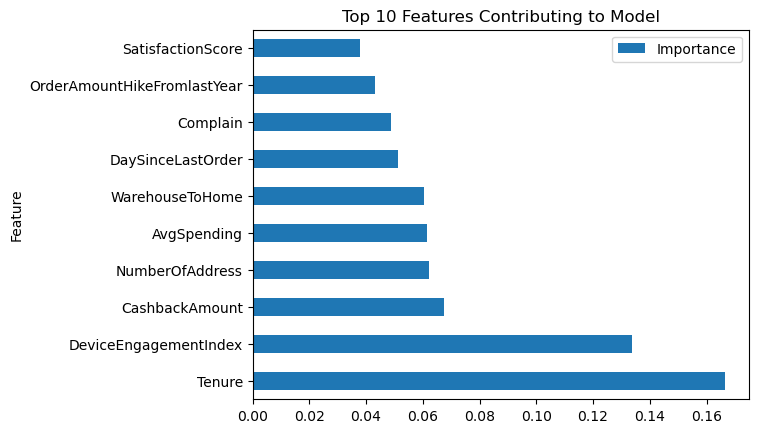

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

# Get numerical feature importances
importances = best_rf.feature_importances_

# List of tuples with variable and importance
feature_list = list(zip(X.columns, importances))

# Sort the feature importances by most important first
feature_list = sorted(feature_list, key = lambda x: x[1], reverse = True)

# DataFrame
feature_importance_df = pd.DataFrame(feature_list, columns=['Feature', 'Importance']).set_index('Feature')

# Plot
plt.figure(figsize=(10,8))
feature_importance_df[:10].plot(kind='barh')
plt.title('Top 10 Features Contributing to Model')
plt.show()

The bar chart visualizes the top 10 features that contribute most significantly to the churn prediction model. These features are indicative of the factors that are most influential in predicting customer churn based on the dataset provided.